In [1]:
import os
import sys  
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define the path to the src directory
src_path = os.path.abspath('../src')

# Check if the src directory exists
if src_path not in sys.path:
    # Append src directory to the Python path
    sys.path.append(src_path)

from data_processing import valid_loader, train_loader, test_loader, labels
from helper import train, evaluate, test, visualise_all_loss

d:\adl\src\data_processing.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_new = pd.concat([df_new, temp_df])


In [2]:
num_classes = len(labels)  # Example number of classes

torch.manual_seed(43)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define AlexNet model
alexnet = models.alexnet(pretrained=True)

# Modify the last layer for multi-class classification
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(num_features, num_classes),  # New fully connected layer
    nn.Sigmoid()  # Add Sigmoid activation
)

# Freeze the weights of the pre-trained layers
for param in alexnet.parameters():
    param.requires_grad = False

# Unfreeze the weights of the last layer
for param in alexnet.classifier.parameters():
    param.requires_grad = True

alexnet.to(device)

# Print the model architecture
print(alexnet)

c:\Users\mandi\anaconda3\envs\adl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mandi\anaconda3\envs\adl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
# Clear CUDA memory
torch.cuda.empty_cache()

# Paths for saving
save_dir = "../models/alexnet_30e/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define Params
criterion = nn.BCELoss()
num_epochs = 30
learning_rates = [0.001, 0.0005]

In [4]:
# Track losses for visualization
train_losses_dict = {}
valid_losses_dict = {}

# Iterate over different learning rates
for lr in learning_rates:
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, alexnet.parameters()), lr=lr)

    best_valid_loss = float('inf')
    train_losses = []  
    valid_losses = []  
    
    for epoch in range(num_epochs):
        avg_train_loss = train(alexnet, train_loader, optimizer, criterion, device)
        train_losses.append(avg_train_loss)
        
        valid_loss = evaluate(alexnet, valid_loader, criterion, device)
        valid_losses.append(valid_loss)
        
        # Print validation loss
        print(f'Learning Rate: {lr}, Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {valid_loss:.4f}')
        
        # Save the best model if validation loss improves
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(alexnet.state_dict(), os.path.join(save_dir, f'best_model_lr_{lr}.pt'))

    # Store losses for visualization
    train_losses_dict[lr] = train_losses
    valid_losses_dict[lr] = valid_losses

# Save losses dictionaries for visualization later
torch.save(train_losses_dict, os.path.join(save_dir, 'train_losses.pt'))
torch.save(valid_losses_dict, os.path.join(save_dir, 'valid_losses.pt'))

Learning Rate: 0.001, Epoch: 1, Train Loss: 0.3782, Validation Loss: 0.3758
Learning Rate: 0.001, Epoch: 2, Train Loss: 0.3658, Validation Loss: 0.3831
Learning Rate: 0.001, Epoch: 3, Train Loss: 0.3618, Validation Loss: 0.3590
Learning Rate: 0.001, Epoch: 4, Train Loss: 0.3566, Validation Loss: 0.3547
Learning Rate: 0.001, Epoch: 5, Train Loss: 0.3491, Validation Loss: 0.3596
Learning Rate: 0.001, Epoch: 6, Train Loss: 0.3440, Validation Loss: 0.3460
Learning Rate: 0.001, Epoch: 7, Train Loss: 0.3427, Validation Loss: 0.3579
Learning Rate: 0.001, Epoch: 8, Train Loss: 0.3369, Validation Loss: 0.3351
Learning Rate: 0.001, Epoch: 9, Train Loss: 0.3356, Validation Loss: 0.3489
Learning Rate: 0.001, Epoch: 10, Train Loss: 0.3318, Validation Loss: 0.3322
Learning Rate: 0.001, Epoch: 11, Train Loss: 0.3262, Validation Loss: 0.3386
Learning Rate: 0.001, Epoch: 12, Train Loss: 0.3217, Validation Loss: 0.3340
Learning Rate: 0.001, Epoch: 13, Train Loss: 0.3229, Validation Loss: 0.3436
Learning

In [9]:
# Evaluate Model
for lr in learning_rates:
    model_path = os.path.join(save_dir, f'best_model_lr_{lr}.pt')  # Change the filename accordingly
    alexnet.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    metrics, loss = test(alexnet, test_loader, criterion, device, num_classes)
    print(metrics, loss)

    Precision  Accuracy    Recall  F1-score
0    0.880000  0.832957  0.131737  0.229167
1    0.823529  0.908578  0.271845  0.408759
2    1.000000  0.887133  0.074074  0.137931
3    0.885714  0.923251  0.326316  0.476923
4    0.888889  0.786682  0.114286  0.202532
5    0.730769  0.931151  0.260274  0.383838
6    0.800000  0.901806  0.044444  0.084211
7    1.000000  0.948081  0.021277  0.041667
8    0.838710  0.737020  0.102362  0.182456
9    1.000000  0.896163  0.061224  0.115385
10   0.000000  0.931151  0.000000  0.000000
11   0.857143  0.887133  0.057143  0.107143
12   1.000000  0.883747  0.037383  0.072072
13   1.000000  0.901806  0.054348  0.103093
14   0.823529  0.914221  0.285714  0.424242 0.3076709152332374
    Precision  Accuracy    Recall  F1-score
0    0.653846  0.838600  0.305389  0.416327
1    0.860000  0.924379  0.417476  0.562092
2    0.826087  0.895034  0.175926  0.290076
3    0.733333  0.924379  0.463158  0.567742
4    0.741667  0.828442  0.423810  0.539394
5    0.870968

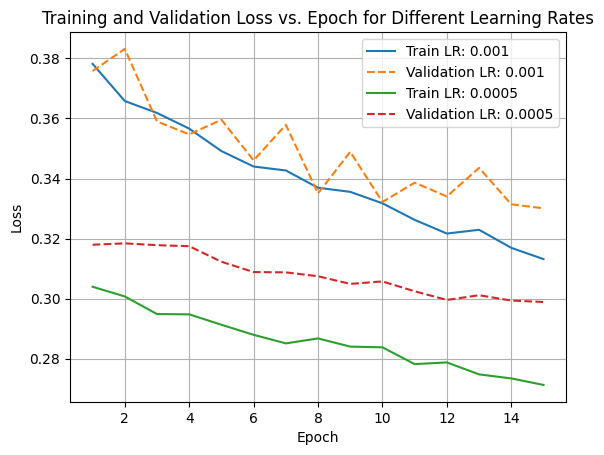

In [7]:
# Plot Train Loss and Validation Loss on the same graph
train_model_path = os.path.join(save_dir, f'train_losses.pt')
valid_model_path = os.path.join(save_dir, f'valid_losses.pt')

visualise_all_loss(train_model_path, valid_model_path)